# Préparation des données et calcul des poids de classes

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Chemin vers les dossiers contenant les images noir et blanc et RGB
base_folder_rgb = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5\Images_rgb'

# Liste des trois races à utiliser
dog_races = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

# Paramètres
img_size = 224  # Taille d'entrée pour ResNet50 ou VGG16 (souvent 224x224)
batch_size = 8

# Data augmentation et préparation des datasets pour RGB
datagen_rgb = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_rgb = datagen_rgb.flow_from_directory(
    base_folder_rgb,
    target_size=(img_size, img_size),
    color_mode='rgb',
    classes=dog_races,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator_rgb = datagen_rgb.flow_from_directory(
    base_folder_rgb,
    target_size=(img_size, img_size),
    color_mode='rgb',
    classes=dog_races,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

def compute_class_weights(generator):
    # Comptabiliser le nombre d'exemples pour chaque classe
    counter = Counter(generator.classes)
    total = float(sum(counter.values()))

    # Calcul des poids de classes
    class_weights = {cls: total / (len(counter) * count) for cls, count in counter.items()}
    return class_weights


### Entraînement intial du modèle ResNet50

In [4]:
# Charger le modèle pré-entraîné ResNet50 (ou VGG16) sans les couches de sortie
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Congeler toutes les couches du modèle de base pour conserver les poids appris
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des nouvelles couches pour s'adapter à notre problème de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling pour réduire la dimensionnalité
x = Dense(256, activation='relu')(x)  # Couche dense avec 256 unités
x = Dropout(0.5)(x)  # Ajout de Dropout pour éviter le surapprentissage
predictions = Dense(3, activation='softmax')(x)  # 3 classes de races de chiens

# Créer le modèle complet
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()  # Afficher le résumé du modèle


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Affichage des courbes de précision et de perte pour le modèle pré-entraîné mais non affiné

Epoch 1/10


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


413/413 ━━━━━━━━━━━━━━━━━━━━ 95s 217ms/step - accuracy: 0.3988 - loss: 1.1947 - val_accuracy: 0.5480 - val_loss: 0.9990
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 93s 226ms/step - accuracy: 0.5059 - loss: 1.0126 - val_accuracy: 0.5589 - val_loss: 0.9710
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 104s 252ms/step - accuracy: 0.5243 - loss: 0.9825 - val_accuracy: 0.5917 - val_loss: 0.9683
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 107s 259ms/step - accuracy: 0.5494 - loss: 0.9776 - val_accuracy: 0.5747 - val_loss: 0.9552
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 110s 267ms/step - accuracy: 0.5668 - loss: 0.9389 - val_accuracy: 0.5772 - val_loss: 0.9590
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 117s 282ms/step - accuracy: 0.5495 - loss: 0.9611 - val_accuracy: 0.5954 - val_loss: 0.9416
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 117s 283ms/step - accuracy: 0.5705 - loss: 0.9342 - val_accuracy: 0.5930 - val_loss: 0.9368
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 118s 286ms/step - accuracy: 0.5754 - loss: 0.9254

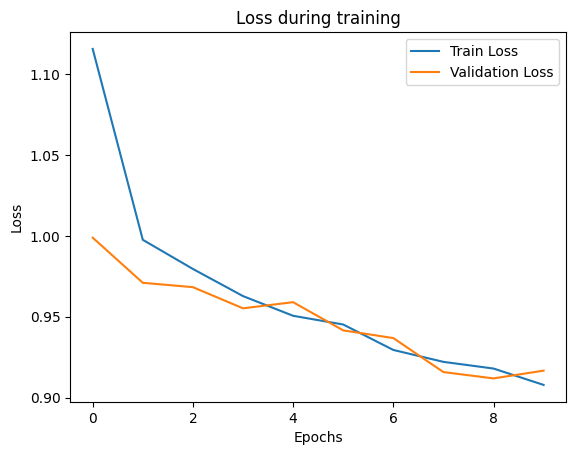

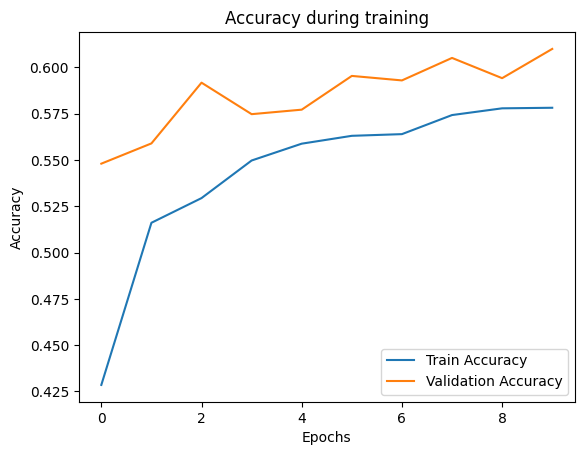

In [5]:
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
class_weights = compute_class_weights(train_generator_rgb)
# Entraîner le modèle sur le dataset
history = model.fit(
    train_generator_rgb,
    validation_data=val_generator_rgb,
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weights = class_weights
)

# Tracer les courbes de perte et d'exactitude
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [6]:
# Évaluer le modèle sur l'ensemble de validation
val_loss, val_acc = model.evaluate(val_generator_rgb)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


103/103 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.5944 - loss: 0.9139
Validation Loss: 0.9118501543998718, Validation Accuracy: 0.5941676497459412


# Affinage du modèle ResNet50

In [7]:
# Décongeler quelques couches du modèle de base pour affiner l'entraînement
for layer in base_model.layers[-10:]:  # On déverrouille les 10 dernières couches
    layer.trainable = True

# Compiler à nouveau le modèle avec un faible taux d'apprentissage
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Réentraîner le modèle
history_fine_tune = model.fit(
    train_generator_rgb,
    validation_data=val_generator_rgb,
    epochs=5,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# Réévaluer le modèle après fine-tuning
val_loss_fine, val_acc_fine = model.evaluate(val_generator_rgb)
print(f"Validation Loss after fine-tuning: {val_loss_fine}, Validation Accuracy after fine-tuning: {val_acc_fine}")


Epoch 1/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 145s 331ms/step - accuracy: 0.5925 - loss: 0.8893 - val_accuracy: 0.5200 - val_loss: 1.0117
Epoch 2/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 132s 321ms/step - accuracy: 0.7089 - loss: 0.6955 - val_accuracy: 0.6391 - val_loss: 0.8232
Epoch 3/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 125s 303ms/step - accuracy: 0.7640 - loss: 0.5933 - val_accuracy: 0.6063 - val_loss: 0.9503
Epoch 4/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 127s 308ms/step - accuracy: 0.8029 - loss: 0.5210 - val_accuracy: 0.6233 - val_loss: 0.9516
Epoch 5/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 124s 301ms/step - accuracy: 0.8455 - loss: 0.4508 - val_accuracy: 0.6343 - val_loss: 0.9237
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.6349 - loss: 0.8363
Validation Loss after fine-tuning: 0.8231531977653503, Validation Accuracy after fine-tuning: 0.6391251683235168


## GRIDSEARCH CV : Optimisation des hyperparamètres et sauvegarde des performances des modèles

In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
import matplotlib.pyplot as plt

# Chemins
base_folder_rgb = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5\Images_rgb'
save_folder = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5'
csv_path = os.path.join(save_folder, 'model_performances.csv')

# Paramètres
img_size = 265
num_classes = 3
batch_sizes = [8, 24]
epochs_list = [5, 20]
optimizers = ['adam', 'rmsprop', 'sgd']
learning_rates = [1e-3, 1e-4, 1e-5]  # Ajout des taux d'apprentissage
models = ['ResNet', 'VGG']
# Liste des trois races à utiliser
dog_races = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

# Charger ou créer le DataFrame des performances
if os.path.exists(csv_path):
    df_performances = pd.read_csv(csv_path)
else:
    df_performances = pd.DataFrame(columns=['model', 'batch_size', 'optimizer', 'learning_rate', 'epochs', 'accuracy', 'loss', 'val_accuracy', 'val_loss'])

# Fonction pour créer le modèle pré-entraîné
def create_pretrained_model(model_name, input_shape, num_classes, optimizer, learning_rate):
    if model_name == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'VGG':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer_instance = tf.keras.optimizers.get(optimizer)
    optimizer_instance.learning_rate = learning_rate
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Fonction de grid search
def grid_search(train_generator, val_generator):
    best_accuracy = 0
    best_model = None
    best_params = {}
    best_history = None

    for model_name in models:
        for batch_size in batch_sizes:
            for epochs in epochs_list:
                for optimizer_name in optimizers:
                    for learning_rate in learning_rates:
                        # Vérifier si la combinaison existe déjà
                        existing_row = df_performances[
                            (df_performances['model'] == model_name) &
                            (df_performances['batch_size'] == batch_size) &
                            (df_performances['optimizer'] == optimizer_name) &
                            (df_performances['learning_rate'] == learning_rate) &
                            (df_performances['epochs'] == epochs)
                        ]
                        if not existing_row.empty:
                            print(f"Skipping: {model_name}, batch_size={batch_size}, optimizer={optimizer_name}, learning_rate={learning_rate}, epochs={epochs}")
                            continue

                        print(f"Testing: {model_name}, batch_size={batch_size}, optimizer={optimizer_name}, learning_rate={learning_rate}, epochs={epochs}")
                        input_shape = (img_size, img_size, 3)
                        model = create_pretrained_model(model_name, input_shape, num_classes, optimizer_name, learning_rate)

                        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                        history = model.fit(
                            train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=1
                        )

                        accuracy = max(history.history['accuracy'])
                        loss = min(history.history['loss'])
                        val_accuracy = max(history.history['val_accuracy'])
                        val_loss = min(history.history['val_loss'])

                        # Enregistrer les résultats dans le DataFrame
                        df_performances.loc[len(df_performances)] = {
                            'model': model_name,
                            'batch_size': batch_size,
                            'optimizer': optimizer_name,
                            'learning_rate': learning_rate,
                            'epochs': epochs,
                            'accuracy': accuracy,
                            'loss': loss,
                            'val_accuracy': val_accuracy,
                            'val_loss': val_loss
                        }

                        # Sauvegarder le DataFrame à chaque étape
                        df_performances.to_csv(csv_path, index=False)

                        if val_accuracy > best_accuracy:
                            best_accuracy = val_accuracy
                            best_model = model
                            best_params = {
                                'model': model_name,
                                'batch_size': batch_size,
                                'optimizer': optimizer_name,
                                'learning_rate': learning_rate,
                                'epochs': epochs
                            }
                            best_history = history
                            print(f"New best model found with accuracy {best_accuracy:.4f}")

    return best_model, best_params, best_accuracy, best_history


# Préparation des générateurs d'images
def prepare_data_generators(batch_size):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_generator = datagen.flow_from_directory(
        base_folder_rgb,
        target_size=(img_size, img_size),
        color_mode='rgb',
        classes=dog_races,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        base_folder_rgb,
        target_size=(img_size, img_size),
        color_mode='rgb',
        classes=dog_races,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

# Exécution de la Grid Search
train_generator_rgb, val_generator_rgb = prepare_data_generators(batch_size=batch_sizes[0])
best_rgb_model, best_rgb_params, best_rgb_accuracy, best_rgb_history = grid_search(train_generator_rgb, val_generator_rgb)



Found 4712 images belonging to 3 classes.
Found 1178 images belonging to 3 classes.
Skipping: ResNet, batch_size=8, optimizer=adam, learning_rate=0.001, epochs=5
Skipping: ResNet, batch_size=8, optimizer=adam, learning_rate=0.0001, epochs=5
Skipping: ResNet, batch_size=8, optimizer=adam, learning_rate=1e-05, epochs=5
Skipping: ResNet, batch_size=8, optimizer=rmsprop, learning_rate=0.001, epochs=5
Skipping: ResNet, batch_size=8, optimizer=rmsprop, learning_rate=0.0001, epochs=5
Skipping: ResNet, batch_size=8, optimizer=rmsprop, learning_rate=1e-05, epochs=5
Skipping: ResNet, batch_size=8, optimizer=sgd, learning_rate=0.001, epochs=5
Skipping: ResNet, batch_size=8, optimizer=sgd, learning_rate=0.0001, epochs=5
Skipping: ResNet, batch_size=8, optimizer=sgd, learning_rate=1e-05, epochs=5
Skipping: ResNet, batch_size=8, optimizer=adam, learning_rate=0.001, epochs=20
Skipping: ResNet, batch_size=8, optimizer=adam, learning_rate=0.0001, epochs=20
Skipping: ResNet, batch_size=8, optimizer=adam

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


589/589 ━━━━━━━━━━━━━━━━━━━━ 370s 626ms/step - accuracy: 0.3153 - loss: 1.2468 - val_accuracy: 0.3820 - val_loss: 1.1163
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 342s 581ms/step - accuracy: 0.3206 - loss: 1.2309 - val_accuracy: 0.4134 - val_loss: 1.1048
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 341s 579ms/step - accuracy: 0.3329 - loss: 1.2187 - val_accuracy: 0.4236 - val_loss: 1.0984
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 343s 582ms/step - accuracy: 0.3619 - loss: 1.1914 - val_accuracy: 0.4270 - val_loss: 1.0941
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 342s 580ms/step - accuracy: 0.3629 - loss: 1.1813 - val_accuracy: 0.4295 - val_loss: 1.0917
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 341s 579ms/step - accuracy: 0.3630 - loss: 1.1868 - val_accuracy: 0.4295 - val_loss: 1.0898
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 339s 575ms/step - accuracy: 0.3733 - loss: 1.1863 - val_accuracy: 0.4304 - val_loss: 1.0881
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 338s 574ms/step - accuracy: 0.3763 - loss: 1.18

NameError: name 'best_params' is not defined

# Affinement du meilleur modèle obtenu avec GRIDSEARCH, lmatrice de confusion et courbes de perte et de validation

C:\Users\pdevi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Found 4712 images belonging to 3 classes.
Found 1178 images belonging to 3 classes.
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


197/197 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.3681 - loss: 1.1790 - val_accuracy: 0.5340 - val_loss: 0.9429
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.5698 - loss: 0.9195 - val_accuracy: 0.6885 - val_loss: 0.8324
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.6918 - loss: 0.7784 - val_accuracy: 0.7190 - val_loss: 0.7627
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.7275 - loss: 0.7077 - val_accuracy: 0.7479 - val_loss: 0.7023
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.7568 - loss: 0.6449 - val_accuracy: 0.7674 - val_loss: 0.6527
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.7850 - loss: 0.5933 - val_accuracy: 0.7912 - val_loss: 0.6115
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.7981 - loss: 0.5465 - val_accuracy: 0.7818 - val_loss: 0.5826
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.8267 - loss: 0.5127 - val_accuracy: 0.796

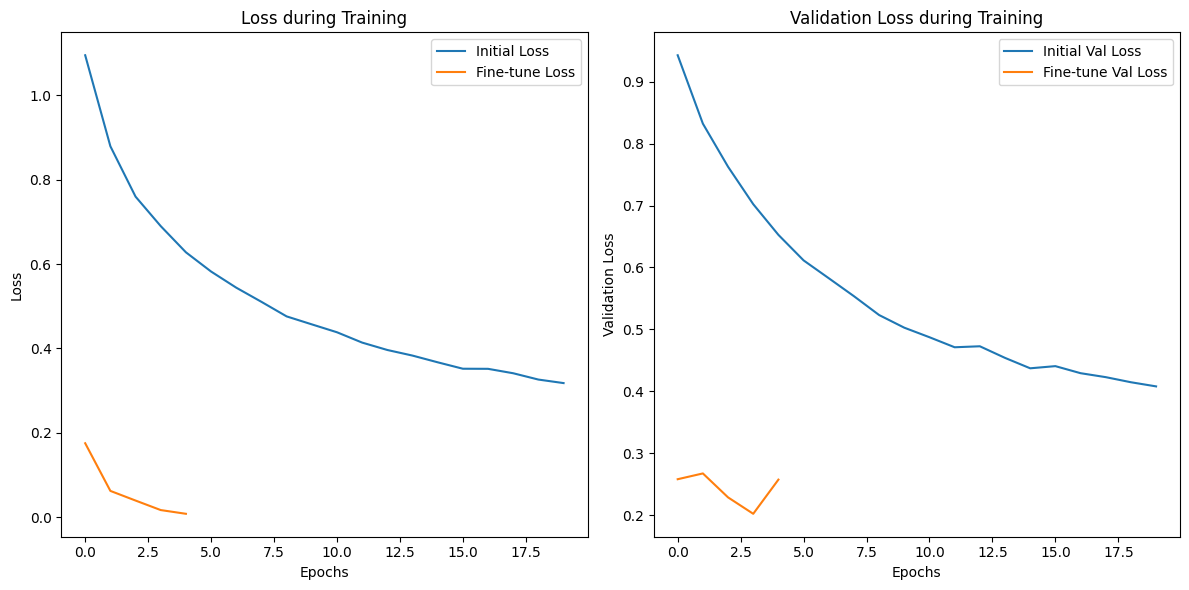

50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step


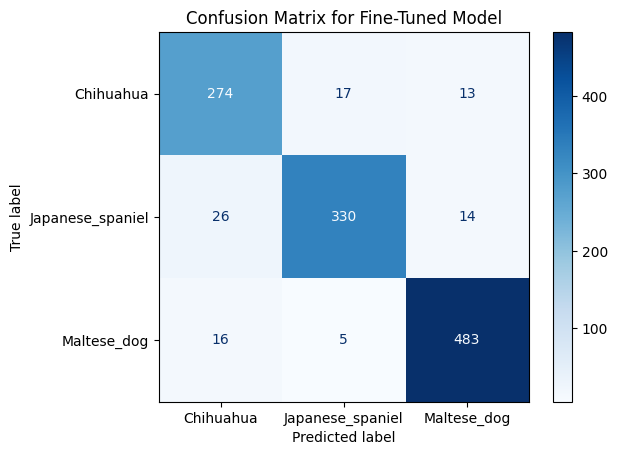

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Chemins
base_folder_rgb = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5\Images_rgb'
save_folder = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5'
csv_path = os.path.join(save_folder, 'model_performances.csv')

# Paramètres
img_size = 265
num_classes = 3
dog_races = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

# Charger le DataFrame des performances
df_performances = pd.read_csv(csv_path)

# Sélectionner le modèle avec la plus faible val_loss
best_row = df_performances.loc[df_performances['val_loss'].idxmin()]
best_params = best_row.to_dict()

# Préparer les générateurs de données
def prepare_data_generators(batch_size):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_generator = datagen.flow_from_directory(
        base_folder_rgb,
        target_size=(img_size, img_size),
        color_mode='rgb',
        classes=dog_races,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        base_folder_rgb,
        target_size=(img_size, img_size),
        color_mode='rgb',
        classes=dog_races,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False  # Important for confusion matrix
    )

    return train_generator, val_generator

train_generator, val_generator = prepare_data_generators(int(best_params['batch_size']))

# Créer le modèle avec les meilleurs paramètres
def create_pretrained_model(input_shape, num_classes, best_params):
    model_name = best_params['model']
    learning_rate = best_params['learning_rate']
    optimizer = best_params['optimizer']

    if model_name == 'ResNet':
        base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'VGG':
        base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    optimizer_instance = tf.keras.optimizers.get(optimizer)
    optimizer_instance.learning_rate = learning_rate
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

best_model = create_pretrained_model((img_size, img_size, 3), num_classes, best_params)

# Entraîner le meilleur modèle initialement
initial_epochs = int(best_params['epochs'])
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=initial_epochs,
    batch_size=int(best_params['batch_size']),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Affinage du modèle
def fine_tune_best_model(best_model, train_generator, val_generator, initial_history):
    for layer in best_model.layers[-10:]:
        layer.trainable = True

    best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history_fine_tune = best_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,
        batch_size=8,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=1
    )

    best_model.save(os.path.join(save_folder, 'best_model_finetuned.keras'))

    plot_loss_curves(initial_history, history_fine_tune)
    display_confusion_matrix(best_model, val_generator)

# Tracer les courbes de perte et de val_loss
def plot_loss_curves(initial_history, fine_tune_history):
    epochs_initial = range(len(initial_history.history['loss']))
    epochs_fine_tune = range(len(fine_tune_history.history['loss']))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_initial, initial_history.history['loss'], label='Initial Loss')
    plt.plot(epochs_fine_tune, fine_tune_history.history['loss'], label='Fine-tune Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss during Training')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_initial, initial_history.history['val_loss'], label='Initial Val Loss')
    plt.plot(epochs_fine_tune, fine_tune_history.history['val_loss'], label='Fine-tune Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss during Training')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Afficher la matrice de confusion
def display_confusion_matrix(model, val_generator):
    val_preds = np.argmax(model.predict(val_generator), axis=1)
    val_labels = val_generator.classes
    cm = confusion_matrix(val_labels, val_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Fine-Tuned Model")
    plt.show()

# Lancer l'affinage
fine_tune_best_model(best_model, train_generator, val_generator, history)


# Calcul du temps moyen d'éxécution du meilleur modèle CNN et du meilleur modèle via Transfer Learning

In [4]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import os

# Chemins vers les modèles et les répertoires d'images
model_path_rgb = "C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Projet_5/best_model_RGB.keras"
model_path_finetuned = "C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Projet_5/best_model_finetuned.keras"
base_folder_rgb = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5\Images_rgb'
base_folder_black = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5\Images_black'
dog_races = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']
img_size = 265

# Fonction pour préparer le générateur de données pour charger les images
def prepare_data_generator(batch_size, is_black_and_white=True):
    datagen = ImageDataGenerator(rescale=1./265)  # Normaliser les pixels en divisant par 265
    color_mode = 'grayscale' if is_black_and_white else 'rgb'  # Mode couleur en fonction du modèle (noir et blanc ou RGB)
    
    # Générateur d'images pour charger les données d'entraînement ou de validation
    generator = datagen.flow_from_directory(
        base_folder_black if is_black_and_white else base_folder_rgb,
        target_size=(img_size, img_size),
        color_mode=color_mode,
        classes=dog_races,
        batch_size=batch_size,
        class_mode='categorical'
    )
    return generator

# Fonction pour calculer le temps moyen de prédiction sur 100 images
def mean_prediction_time(model, generator):
    total_time = 0  # Initialiser le temps total de prédiction
    num_images = 100  # Nombre d'images pour le calcul
    count = 0  # Compteur d'images traitées
    
    for images, _ in generator:
        for img in images:
            start_time = time.time()  # Démarrer le chronomètre
            _ = model.predict(np.expand_dims(img, axis=0), verbose=0)  # Prédire pour une image
            total_time += time.time() - start_time  # Calculer le temps écoulé pour la prédiction
            count += 1
            if count >= num_images:  # Arrêter après 100 images
                break
        if count >= num_images:
            break
    
    mean_time = total_time / num_images  # Calculer le temps moyen
    return mean_time

# Charger les deux modèles
model_rgb = load_model(model_path_rgb)
model_finetuned = load_model(model_path_finetuned)

# Préparer les générateurs de données
generator_rgb = prepare_data_generator(batch_size=8, is_black_and_white=False)

# Calculer le temps moyen de prédiction
mean_time_rgb = mean_prediction_time(model_rgb, generator_rgb)
mean_time_finetuned = mean_prediction_time(model_finetuned, generator_rgb)

# Afficher les résultats
print(f"Temps moyen de prédiction pour le modèle RGB : {mean_time_rgb:.4f} secondes")
print(f"Temps moyen de prédiction pour le modèle affiné : {mean_time_finetuned:.4f} secondes")


Found 5890 images belonging to 3 classes.
Temps moyen de prédiction pour le modèle RGB : 0.0592 secondes
Temps moyen de prédiction pour le modèle affiné : 0.1561 secondes
